In [46]:
import pandas as pd
import numpy as np

df = pd.read_json("transactions.json")
print("Columns in dataset:", df.columns.tolist())


Columns in dataset: ['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt']


In [47]:
import pandas as pd
import numpy as np
df = pd.read_json("transactions.json")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
def extract_amount(row):
    if isinstance(row, dict):
        return pd.to_numeric(row.get("amount", 0), errors="coerce")
    return 0

df["amount"] = df["actionData"].apply(extract_amount)
action_counts = df.pivot_table(index="userWallet", columns="action", aggfunc="size", fill_value=0)

numeric_features = df.groupby("userWallet").agg({
    "amount": ["mean", "std", "sum"],
    "timestamp": ["min", "max"]
})

time_gaps = (
    df.sort_values("timestamp")
    .groupby("userWallet")["timestamp"]
    .apply(lambda x: np.std(np.diff(x.dropna().values.astype("int64")) / 1e9))  
).reset_index(name="avg_time_gap")

features = pd.concat([action_counts, numeric_features], axis=1)
features.columns = [
    "_".join(col) if isinstance(col, tuple) else col for col in features.columns
]
features = features.merge(time_gaps, on="userWallet", how="left")
features.fillna(0, inplace=True)
print("✅ Feature engineering complete. Sample:")
print(features.head())

C:\Users\Aashutosh Kumar\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in scalar add
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Aashutosh Kumar\AppData\Roaming\Python\Python312\site-packages\pandas\core\groupby\ops.py:403: RuntimeWarning: overflow encountered in scalar add
  func(
C:\Users\Aashutosh Kumar\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Aashutosh Kumar\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Aashutosh Kumar\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


✅ Feature engineering complete. Sample:
                                   userWallet  borrow  deposit  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6       0        1   
1  0x000000000051d07a4fb3bd10121a343d85818da6       0        1   
2  0x000000000096026fb41fc39f9875d164bd82e2dc       0        2   
3  0x0000000000e189dd664b9ab08a33c4839953852c       0        0   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee      15      250   

   liquidationcall  redeemunderlying  repay              amount_mean  \
0                0                 0      0             2000000000.0   
1                0                 0      0  145000000000000000000.0   
2                0                 0      0       2500000000000000.0   
3                0                17      0     284429242933348160.0   
4                0               130      4  434839023057032445952.0   

     amount_std                  amount_sum       timestamp_min  \
0  0.000000e+00                  2000000000 2021-08-17 05:29:26

In [48]:
from sklearn.preprocessing import MinMaxScaler
numeric_cols = features.select_dtypes(include=["float64", "int64"]).columns
X = features[numeric_cols]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
y = (
    features.get("deposit", 0) +
    features.get("repay", 0) -
    features.get("liquidationcall", 0)
).clip(lower=0)
from sklearn.preprocessing import MinMaxScaler
y_scaled = MinMaxScaler().fit_transform(y.values.reshape(-1, 1)).flatten()
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


C:\Users\Aashutosh Kumar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1395 - mae: 0.3421 - val_loss: 0.0044 - val_mae: 0.0383
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0039 - val_mae: 0.0270
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0262 - val_loss: 0.0037 - val_mae: 0.0241
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mae: 0.0245 - val_loss: 6.3398e-04 - val_mae: 0.0160
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0089e-04 - mae: 0.0166 - val_loss: 3.4731e-04 - val_mae: 0.0116
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4300e-04 - mae: 0.0127 - val_loss: 2.3583e-04 - val_mae: 0.0101
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6774e-04 - mae: 0.0128 - val_loss: 1.9251e-04 - val_mae: 0.0092
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7978e-04 - mae: 0.0114 - val_loss: 1.8351e-04 - val_mae: 0.0089
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

In [50]:
predicted_scores = model.predict(X_scaled).flatten() * 1000
features["credit_score"] = predicted_scores.round(2)
features[["userWallet", "credit_score"]].to_csv("wallet_scores.csv", index=False)
print("✅ Credit scores saved to wallet_scores.csv")

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Credit scores saved to wallet_scores.csv


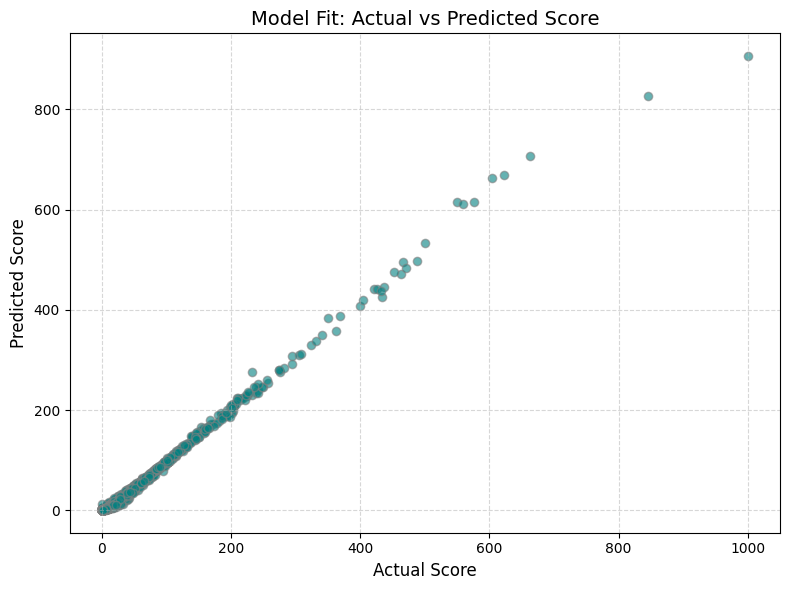

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(y_scaled * 1000, features["credit_score"], alpha=0.6, color="teal", edgecolor="gray")
plt.title("Model Fit: Actual vs Predicted Score", fontsize=14)
plt.xlabel("Actual Score", fontsize=12)
plt.ylabel("Predicted Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
import numpy as np
import argparse
# ... rest of your script
!python score_wallets.py --input transactions.json --output wallet_scores.csv